In [8]:
"""

                        ~~~~ Hypothesis Testing ~~~~
                t-tests, proportion tests, chi-square tests

1. The Basics of Hypothesis Testing
 - sampling means, statistical significance, z-scores, p-values, proportion sample
 - left/right/two tail, confidence intervals, A/B tests, Type I & II errors

2. Two-sample and ANOVA tests
 - hypothesis testing workflow, t-tests, t-stats, t-distribution, paired t-tests
 - analysis of variables tests, ttest(), pairwise t-tests

3. Proportion Tests
 - one sample proportion tests, two sample proportion tests, proportions_ztest()
 - chi square tests, chi square distribution, chi square goodness of fit tests

4. Non-Parametric Tests
 - Wilcoxon signed-rank test, non parametric anova tests, unpaired t-tests
 - Wilcoxon Mann Whitney test, Kruskal Wallis test


"""

import pandas
import numpy as np
import scipy
from scipy.stats import iqr, uniform, binom, norm, poisson, expon, t
import matplotlib.pyplot as plt
import seaborn as sns

data_folder = '../../data'
# types: A = super center, B = discount store, C = neighborhood market
df_walmart = pandas.read_csv(f'{data_folder}/walmart_sales_subset.csv', index_col=0)
df_homeless = pandas.read_csv(f'{data_folder}/homeless.csv', index_col=0)
df_amir = pandas.read_csv(f'{data_folder}/amir_deals.csv', index_col=0)
# simplify df_amir to just 100 observations
df_amir = pandas.DataFrame(df_amir[:100])
df_mph = pandas.read_csv(f'{data_folder}/mpg.csv')
df_stack_overflow = pandas.read_feather(f'{data_folder}/stack_overflow.feather')

In [21]:
display(df_stack_overflow.info())
display(df_stack_overflow.head())
len(df_stack_overflow)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261 entries, 0 to 2260
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   respondent                         2261 non-null   float64 
 1   main_branch                        2261 non-null   object  
 2   hobbyist                           2261 non-null   object  
 3   age                                2261 non-null   float64 
 4   age_1st_code                       2261 non-null   float64 
 5   age_first_code_cut                 2261 non-null   object  
 6   comp_freq                          2261 non-null   object  
 7   comp_total                         2261 non-null   float64 
 8   converted_comp                     2261 non-null   float64 
 9   country                            2261 non-null   object  
 10  currency_desc                      2261 non-null   object  
 11  currency_symbol                    2261 non

None

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30
3,125.0,"I am not primarily a developer, but I write co...",Yes,41.0,30.0,adult,Monthly,200000.0,2000000.0,United States,...,Appropriate in length,No,None,None,None,Just as welcome now as I felt last year,40.0,11.0,11.0,At least 30
4,147.0,"I am not primarily a developer, but I write co...",No,28.0,15.0,adult,Yearly,50000.0,37816.0,Canada,...,Appropriate in length,No,"Another engineering discipline (such as civil,...",None,Express;Flask,Just as welcome now as I felt last year,40.0,5.0,3.0,Under 30


2261

# Hypothesis Tests & z-scores

1.7205014829363723

0.9573293378247446

0.04267066217525539

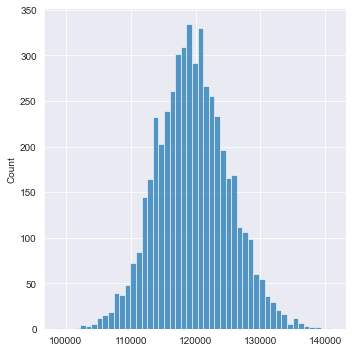

In [33]:
'''
Hypothesis: The mean salary of data scientists is 110k
 - point estimate (aka sample stat)
 - standard error is the standard deviation of the bootstrap.dist
 - z score = (orig_stat - hypothetical_stat) / standard_error
  -- the z score is the "standardized value"
 - The 'probability density function' is basically The normal distribution
  -- This is referred to as the z-distribution (which is related to the z-score)
'''
mean_salary = df_stack_overflow['converted_comp'].mean()
hypothetical_salary = 110000
stack_overflow_bootstrap_dist = []
for i in range(5000):
    stack_overflow_bootstrap_dist.append(
        np.mean(df_stack_overflow.sample(frac=1, replace=True)['converted_comp']))

standard_error = np.std(stack_overflow_bootstrap_dist,ddof=1)
z_score = (mean_salary - hypothetical_salary )/ standard_error
# left-tailed alternative hypothesis (data.sci make less than average)
p_val_left = norm.cdf(z_score,loc=0,scale=1)
# right-tailed alt.hypo (data.sci make more than average)
p_val_right = 1 - norm.cdf(z_score,loc=0,scale=1)

# output
display(z_score)
display(p_val_left)
display(p_val_right)
sns.displot(data=stack_overflow_bootstrap_dist)
plt.show()

# Two-Sample & ANOVA tests

In [37]:
'''
Performing t-tests
 - t-stat
Calculating p-values from t-stats
 - t-distribution
Paired t-tests
 - ttest()
ANOVA tests
 - pairwise t-tests

Z Score:
 z = (sample_stat - population_estimate_stat) / standard_error

T Stat:
 std_err_diff = "square root of (SD1_squared / s1_size) + (SD2_squared / s2_size)"
 t = ("difference of sample stats" - "difference of population estimate stats"?) / std_err_diff
'''

# getting the t-stat of the null hypothesis from the sample
x_mean = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].mean()
x_sd = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].std()
x_count = df_stack_overflow.groupby('age_first_code_cut')['converted_comp'].count()
display(x_mean,x_sd,x_count)
numerator = (x_mean['child'] - x_mean['adult'])
denominator = np.sqrt(x_sd['child']**2/x_count['child'] + x_sd['adult']**2/x_count['adult'])
t_stat =  numerator / denominator
t_stat

age_first_code_cut
adult    111313.311047
child    132419.570621
Name: converted_comp, dtype: float64

age_first_code_cut
adult    271546.521729
child    255585.240115
Name: converted_comp, dtype: float64

age_first_code_cut
adult    1376
child     885
Name: converted_comp, dtype: int64

1.8699313316221844

In [42]:
alpha = 0.10
deg_of_free = x_count['child'] + x_count['adult'] - 2
# right-tail
p_val = 1 - t.cdf(t_stat,df=deg_of_free)
display(deg_of_free, t_stat, p_val)

2259

1.8699313316221844

0.030811302165157595

In [43]:
print('Reject null hypothesis?', p_val <= alpha)

Reject null hypothesis? True
